In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom, norm
from tqdm import tqdm
import pandas as pd

from protein_conformal.util import *
# from util import simplifed_venn_abers_prediction

In [3]:
# conformal_pfam.npy is a len 10,000 list of dictionaries of len 10,000 hits. 
# This isn't the most valid way to do this, because it incoporates proteins from the training set into calibration. 

# We chose to do this because the previous approach didn't have enough new examples to calibrate.
# data = np.load('/data/ron/protein-conformal/data/conformal_pfam_with_lookup_dataset.npy', allow_pickle=True)
data = np.load('/data/ron/protein-conformal/data/pfam_new_proteins.npy', allow_pickle=True)
print(len(data))
print(len(data[0]['S_i']))

1864
100000


## Look at distribution of $S_{ij}$ across retrieved hits

Text(0.5, 1.0, 'Protein-vec: Histogram of Similarity Scores')

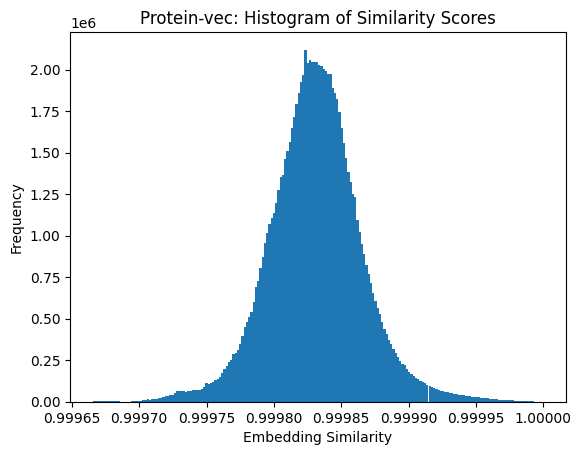

In [4]:
sims = np.stack([query['S_i'] for query in data], axis=0)
plt.hist(sims.flatten(), bins=200)
plt.xlabel('Embedding Similarity')
plt.ylabel('Frequency')
plt.title('Protein-vec: Histogram of Similarity Scores')
# plt.show()
# plt.savefig('/data/ron/protein-conformal/data/pvec_histogram.pdf', format='pdf')

## FDR for exact hits on Pfam

In [4]:
# sims, labels = get_sims_labels(data, partial=False)
labels = np.stack([query['exact'] for query in data], axis=0)
sims = np.stack([query['S_i'] for query in data], axis=0)

In [5]:
labels.shape, sims.shape

((1864, 100000), (1864, 100000))

In [12]:
np.sum(labels, axis=0)

array([1508, 1456, 1380, ...,    0,    0,    0])

In [6]:
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels, lam) for lam in lambdas]
# percentage_of_discoveries_rsk = [percentage_of_discoveries(sims, labels, lam) for lam in lambdas]

In [7]:
np.max(fnr)

0.9999603121056015

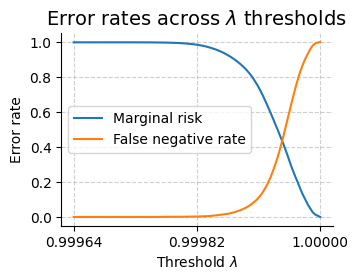

In [8]:
# Plot FDR + FNR as a function of lambda
plt.figure(figsize=(3.5, 2.5))
plt.plot(lambdas, risks, label='Marginal risk')
# plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
# Customize the plot
plt.xlabel(r'Threshold $\lambda$', fontsize=10)
plt.ylabel('Error rate', fontsize=10)
plt.title(r'Error rates across $\lambda$ thresholds', fontsize=14)

# Adjust x-ticks to make the x-axis less crowded
plt.xticks(np.linspace(np.min(lambdas), np.max(lambdas), 3), [f'{x:.5f}' for x in np.linspace(np.min(lambdas), np.max(lambdas), 3)], fontsize=10)
plt.yticks(fontsize=10)
plt.legend()
# Customize grid and remove top and right spines
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/pvec_error_rates.pdf', format='pdf', bbox_inches='tight')

## FDR / FNR on partial hits on Pfam

In [28]:
# Plot FDR as a function of lambda
sims, labels_partial = get_sims_labels(data, partial=True)
# labels_partial = np.stack([(np.sum(query['partial'], axis=1) >= 1) if len(np.array(query['partial']).shape) > 1 else query['partial'] for query in data], axis=0)
# sims = np.stack([query['S_i'] for query in data], axis=0)
lambdas = np.linspace(sims.min(),sims.max(),100)
risks = [risk(sims, labels_partial, lam) for lam in lambdas]
risks_no_empties = [risk_no_empties(sims, labels_partial, lam) for lam in lambdas]
# no_empties: as we increase lambda, the number of empty sets increases. We filter out the empty sets and calculate the risk.
fnr = [calculate_false_negatives(sims, labels_partial, lam) for lam in lambdas]

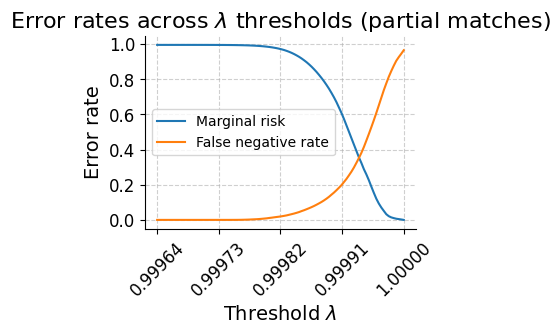

In [31]:
# Plot FDR + FNR as a function of lambda
plt.figure(figsize=(3.5, 2.5))
plt.plot(lambdas, risks, label='Marginal risk')
# plt.plot(lambdas, risks_no_empties, label='Risk (no empty sets)')
# plt.plot(lambdas, percentage_of_discoveries_rsk, label='Percentage of discoveries')
plt.plot(lambdas, fnr, label='False negative rate')
plt.xlabel(r'Threshold $\lambda$', fontsize=10)
plt.ylabel('Error rate', fontsize=10)
plt.title(r'Error rates across $\lambda$ thresholds (partial match)', fontsize=14)
# Adjust x-ticks to make the x-axis less crowded
plt.xticks(np.linspace(np.min(lambdas), np.max(lambdas), 5), [f'{x:.5f}' for x in np.linspace(np.min(lambdas), np.max(lambdas), 5)], fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
sns.despine()
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/pvec_error_rates_partial.pdf', format='pdf')

## Learn then test for FDR

In [36]:
alpha = 0.1
lhat, risk_0 = get_thresh_FDR(labels, sims, alpha, delta=0.5, N=100)
print(f'alpha={alpha}, lhat={lhat}, risk={risk_0}')

alpha=0.1, lhat=0.9999820198675599, risk=0.07214881222814735


In [45]:
risks = []
tprs = []
lhats = []
fdr_cals = []
alpha = 0.1
num_trials = 100
n_calib = 100
for trial in tqdm(range(num_trials)):
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:2*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    # sims, labels = get_sims_labels(cal_data, partial=False)
    lhat, fdr_cal = get_thresh_FDR(y_cal, X_cal, alpha, delta=0.5, N=100)
    fdr_cals.append(fdr_cal)
    lhats.append(lhat)
    # print(X_test.shape)
    # print(y_test_exact.shape)
    risks.append(risk(X_test, y_test_exact, lhat))
    tprs.append(calculate_true_positives(X_test, y_test_exact, lhat))
    # print(lhat)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [09:33<00:00,  5.73s/it]


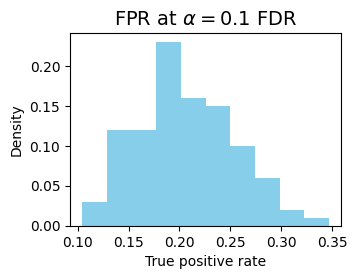

In [91]:
plt.figure(figsize=(3.5, 2.5))
weights = np.ones_like(risks)/float(len(risks))
plt.hist(np.array(tprs), weights=weights, color='skyblue')
plt.xlabel('True positive rate', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(rf'FPR at $\alpha={alpha}$ FDR', fontsize=14)
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/tpr_fdr.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 1.0, 'Protein-vec: Histogram of Thresholds')

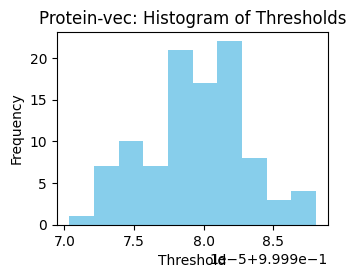

In [69]:
plt.figure(figsize=(3.5, 2.5))
plt.hist(np.array(lhats), color='skyblue')
plt.xlabel('Threshold')
plt.ylabel('Density')
plt.title('Protein-vec: Histogram of Thresholds')

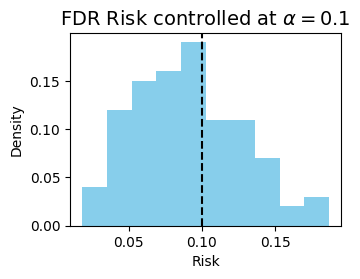

In [89]:
plt.figure(figsize=(3.5, 2.5))
weights = np.ones_like(risks)/float(len(risks))
plt.hist(np.array(risks), weights=weights, label='Risk', color='skyblue')
plt.axvline(alpha, color='black', linestyle='--')
plt.xlabel('Risk', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(rf'FDR Risk controlled at $\alpha={alpha}$', fontsize=14)
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/fdr_control.pdf', format='pdf', bbox_inches='tight')

### FNR

In [9]:
num_trials = 100
alpha = 0.1
n_calib = 100
fnrs = []
retrieved_data_percentages = []
for trial in tqdm(range(num_trials)):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:3*n_calib]

    # lhat = get_thresh_new(cal_data, alpha)
    # lhat = get_thresh(cal_data, alpha)
    # error, fraction_inexact, error_partial, fraction_partial = validate_lhat(test_data, lhat)

    # TODO: add lhat to print
    # TODO: difference between get_thresh and get_thresh_FDR
    # print(f'Trial {trial+1}: lhat: {lhat}, Ex&!Id/Ex: {error:.2f}, In/Id: {fraction_inexact:.2f}, Pa&!Id/Pa: {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f}')

    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    _, y_test_partial = get_sims_labels(test_data, partial=True)
    lhat = get_thresh_new(X_cal, y_cal, alpha)
    error, fraction_inexact, error_partial, fraction_partial, fpr = validate_lhat_new(X_test, y_test_partial, y_test_exact, lhat)
    # print(f'Trial {trial+1}: lhat: {lhat}, Ex&!Id/Ex (FNR): {error:.2f}, In/Id (FDR): {fraction_inexact:.2f}, Pa&!Id/Pa (FNR partial): {error_partial:.2f}, Pa&Id/Id: {fraction_partial:.2f} (TPR partial), FPR: {fpr:.2f}')
    fnrs.append(error)
    retrieved_data_percentages.append((X_test.flatten() >= lhat).sum() / len(X_test.flatten()))
    

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [05:36<00:00,  3.36s/it]


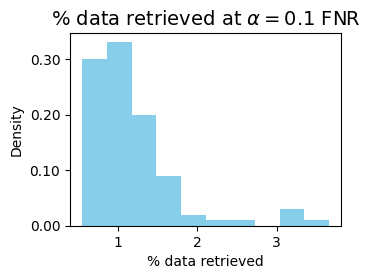

In [13]:
plt.figure(figsize=(3.5, 2.5))
weights = np.ones_like(retrieved_data_percentages)/float(len(retrieved_data_percentages))
plt.hist(np.array(retrieved_data_percentages) * 100, weights=weights, color='skyblue')
plt.xlabel('% data retrieved', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(rf'% data retrieved at $\alpha={alpha}$ FNR', fontsize=14)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.2f}'))
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/data_retrived.pdf', format='pdf', bbox_inches='tight')

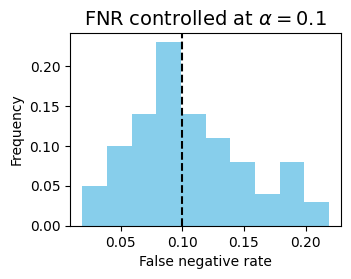

In [11]:
plt.figure(figsize=(3.5, 2.5))
weights = np.ones_like(fnrs)/float(len(fnrs))
plt.hist(np.array(fnrs), weights=weights, color='skyblue')
plt.axvline(alpha, color='black', linestyle='--')
plt.xlabel('False negative rate', fontsize=10)
plt.ylabel('Frequency', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title(rf'FNR controlled at $\alpha={alpha}$', fontsize=14)
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/fnr_control.pdf', format='pdf', bbox_inches='tight')


## Venn-Abers prediction

In [92]:
n_calib = 50

np.random.shuffle(data)
cal_data = data[:n_calib]
test_data = data[n_calib:3*n_calib]


X_cal, y_cal = get_sims_labels(cal_data, partial=False)
X_test, y_test_exact = get_sims_labels(test_data, partial=False)
# flatten the data
X_cal = X_cal.flatten()
y_cal = y_cal.flatten()
X_test = X_test.flatten()
y_test_exact = y_test_exact.flatten()


# np.random.shuffle(data)
# X_cal = sims[:n_calib, :].flatten()
# y_cal = labels[:n_calib].flatten()
# cal_data = data[:n_calib]
# X_test = sims[n_calib:2*n_calib, :].flatten()
# y_test = labels[n_calib:2*n_calib].flatten()
# test_data = data[n_calib:3*n_calib]
# ir = get_isotone_regression(cal_data)
# sims, labels = get_sims_labels(test_data, partial=False)
p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[0])


In [93]:
p_0, p_1

(1.0, 0.9940594)

In [14]:
def run_trial(data, n_calib):
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:3*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    X_test, y_test_exact = get_sims_labels(test_data, partial=False)
    # flatten the data
    X_cal = X_cal.flatten()
    y_cal = y_cal.flatten()
    X_test = X_test.flatten()
    y_test_exact = y_test_exact.flatten()

    # generate random indices in the test set
    i = np.random.randint(0, len(X_test))
    # i_s = np.random.randint(0, len(X_test), int(len(X_test) * args.percent_sva_test))

    p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[i])
    result = (p_0, p_1, X_test[i], y_test_exact[i])
    return result

num_trials = 1000
sva_results = []
n_calib = 50
for trial in tqdm(range(num_trials)):
    # print(f'Running trial {i+1} of {args.num_trials}')
    sva_results.append(run_trial(data, n_calib))

# sva_results = []
# # generate random indices in the test set
# i_s = np.random.randint(0, len(X_test), 10000)

# for _, i in tqdm(enumerate(i_s)):
#     p_0, p_1 = simplifed_venn_abers_prediction(X_cal, y_cal, X_test[i])
#     sva_results.append((p_0, p_1, y_test_exact[i]))
    # print(f'Prediction: {p_1}, Actual: {y_test[i]}')

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [15:42<00:00,  1.06it/s]


In [16]:
abs_p = [np.abs(p[0] - p[1]) for p in sva_results]

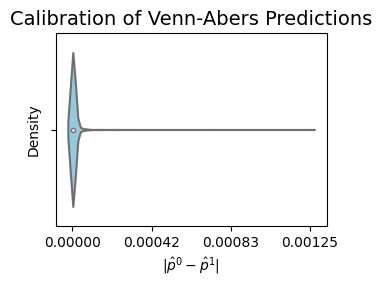

In [24]:
plt.figure(figsize=(3.5, 2.5))
# weights = np.ones_like(abs_p) / len(abs_p)
# plt.hist(abs_p, bins=50, color='skyblue', weights=weights)
sns.violinplot(x=abs_p, color='skyblue')
plt.xlabel(r'$|\hat{p}^0 - \hat{p}^1|$', fontsize=10)
plt.ylabel('Density', fontsize=10)
plt.title('Calibration of Venn-Abers Predictions', fontsize=14)
# plt.xticks(fontsize=10)
x_ticks = np.linspace(min(abs_p), max(abs_p), num=4)
plt.xticks(x_ticks, [f'{tick:.5f}' for tick in x_ticks], fontsize=10)
plt.yticks(fontsize=10)
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.savefig('/data/ron/protein-conformal/figs/sva_calibration.pdf', format='pdf')
plt.savefig('/data/ron/protein-conformal/figs/pfam_new/sva_calibration.pdf', format='pdf', bbox_inches='tight')

<Figure size 350x250 with 0 Axes>

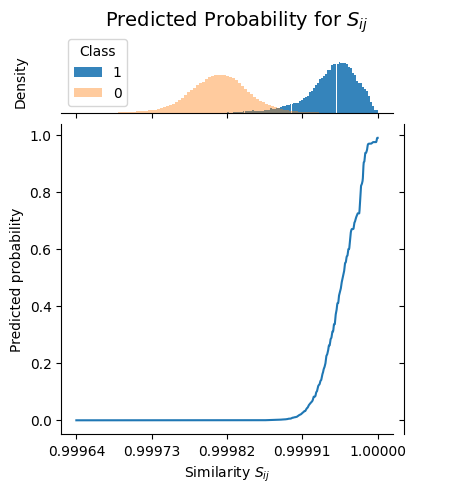

In [120]:
num_trials = 1
n_calib = 1000
for trial in range(num_trials):
    # Randomly split data into calibration and test sets
    np.random.shuffle(data)
    cal_data = data[:n_calib]
    test_data = data[n_calib:2*n_calib]
    X_cal, y_cal = get_sims_labels(cal_data, partial=False)
    ir = get_isotone_regression(X_cal.flatten(), y_cal.flatten())
    X_test, y_test = get_sims_labels(test_data, partial=False)
    preds = ir.predict(X_test.flatten())

    plt.figure(figsize=(3.5, 2.5))
    g = sns.JointGrid(height=5, ratio=5, space=0.2)
    # g.ax_joint.scatter(X_test[y_test], y_test[y_test], alpha=0.002)
    # g.ax_joint.scatter(X_test[~y_test], y_test[~y_test], alpha=0.002)
    x = np.linspace(np.min(X_test), np.max(X_test), 1000)

    phats = ir.predict(x)
    g.ax_joint.plot(x, phats)
    g.set_axis_labels(r'Similarity $S_{ij}$', 'Predicted probability', fontsize=10)

    weights_1 = np.ones_like(y_test[y_test]) / len(y_test[y_test])
    g.ax_marg_x.hist(X_test[y_test], label='1', alpha=0.9, bins=100, density=True, weights=weights_1)

    weights_0 = np.ones_like(y_test[~y_test]) / len(y_test[~y_test])
    g.ax_marg_x.hist(X_test[~y_test], label='0', alpha=0.4, bins=100, density=True, weights=weights_0)
    # Manually create a new axis for the marginal histogram and set its y-axis label
    ax_marg_y = g.figure.add_axes(g.ax_marg_x.get_position())
    ax_marg_y.yaxis.tick_right()
    # ax_marg_y.set_ylabel('Density', labelpad=15, fontsize=10)
    ax_marg_y.set_ylabel('Density', fontsize=10)
    ax_marg_y.yaxis.set_label_position('left')
    ax_marg_y.set_yticks([])
    ax_marg_y.set_frame_on(False)
    ax_marg_y.set_xticks([])

    # Set fewer x-axis ticks
    x_ticks = np.linspace(np.min(X_test), np.max(X_test), 5)
    g.ax_joint.set_xticks(x_ticks)
    g.ax_joint.set_xticklabels([f'{tick:.5f}' for tick in x_ticks], fontsize=10)

    handles, labels = g.ax_marg_x.get_legend_handles_labels()
    g.ax_marg_x.legend(handles, labels, title='Class')

    # Optionally remove the spines for a cleaner look
    # g.ax_marg_x.spines['bottom'].set_visible(False)
    # g.ax_marg_x.spines['top'].set_visible(False)
    # g.ax_marg_x.spines['left'].set_visible(False)
    # g.ax_marg_x.spines['right'].set_visible(False)
    
    plt.suptitle(r'Predicted Probability for $S_{ij}$', y=1.05, fontsize=14)
    # Adjust subplots to fit the figure size
    plt.subplots_adjust(left=0.15, right=0.95, top=.95, bottom=0.2)
    plt.savefig('/data/ron/protein-conformal/figs/pfam_new/isotonic_regression.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    
    ##print()
    #plt.figure()
    #sim_bins = np.linspace(min(sims), max(sims), 100)
    #plt.hist(np.array(sims)[np.array(labels)], bins=sim_bins, alpha=0.5, label='1')
    #plt.hist(np.array(sims)[~np.array(labels)], bins=sim_bins, alpha=0.5, label='0')
    #plt.legend()

    